In [1]:
import cv2
import numpy as np
import pandas as pd
import ast
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("paper")
sns.set(font='serif')
sns.set_style("white", {
    "font.family": "serif",
    "font.serif": ["Times", "Palatino", "serif"]
})

plt.rcParams.update({
        'figure.dpi': '150'
})

In [2]:
# Load the dataset
data = pd.read_excel('height_and_pose.xlsx')

# Split the dataset into training and validation sets
train_data = data[:6]
val_data = data[6:]

# Normalize the depthmap images
def normalize_depthmap(img):
    return cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

train_images = []
val_images = []
for idx, row in train_data.iterrows():
    img_id = str(row['Depthmap Image'])
    img_path = f'depthmap/{img_id}.jpg'
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = normalize_depthmap(img)
    train_images.append(img)

for idx, row in val_data.iterrows():
    img_id = row['Depthmap Image']
    img_path = f'depthmap/{img_id}.jpg'
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = normalize_depthmap(img)
    val_images.append(img)

# Convert pose keypoints to binary mask
def pose_keypoint_mask(keypoints, img_shape, sigma=10):
    mask = np.zeros(img_shape, dtype=np.float32)
    for keypoint in keypoints:
        body_part = list(keypoint.keys())[0]  # Get the body part name
        x, y = int(keypoint[body_part]['x']), int(keypoint[body_part]['y'])
        if x < 0 or x >= img_shape[1] or y < 0 or y >= img_shape[0]:
            continue
        mask[y, x] = 1
    mask = cv2.GaussianBlur(mask, (0, 0), sigma)
    return mask

train_masks = []
val_masks = []
for idx, row in train_data.iterrows():
    keypoints = ast.literal_eval(row['Pose'])[0]['key_points_coordinate']
    img_shape = train_images[idx].shape
    mask = pose_keypoint_mask(keypoints, img_shape)
    train_masks.append(mask)

for idx, row in val_data.iterrows():
    keypoints = ast.literal_eval(row['Pose'])[0]['key_points_coordinate']
    img_shape = val_images[idx-6].shape
    mask = pose_keypoint_mask(keypoints, img_shape)
    val_masks.append(mask)

# Concatenate depthmap images and pose keypoint masks along the channel dimension
def combine_inputs(img, mask):
    img = img[..., np.newaxis]
    mask = mask[..., np.newaxis]
    return np.concatenate((img, mask), axis=-1)

train_inputs = []
val_inputs = []
for i in range(len(train_images)):
    img = train_images[i]
    mask = train_masks[i]
    combined = combine_inputs(img, mask)
    train_inputs.append(combined)

for i in range(len(val_images)):
    img = val_images[i]
    mask = val_masks[i]
    combined = combine_inputs(img, mask)
    val_inputs.append(combined) 

val_outputs = val_data['Height(cm)']
train_outputs = train_data['Height(cm)']


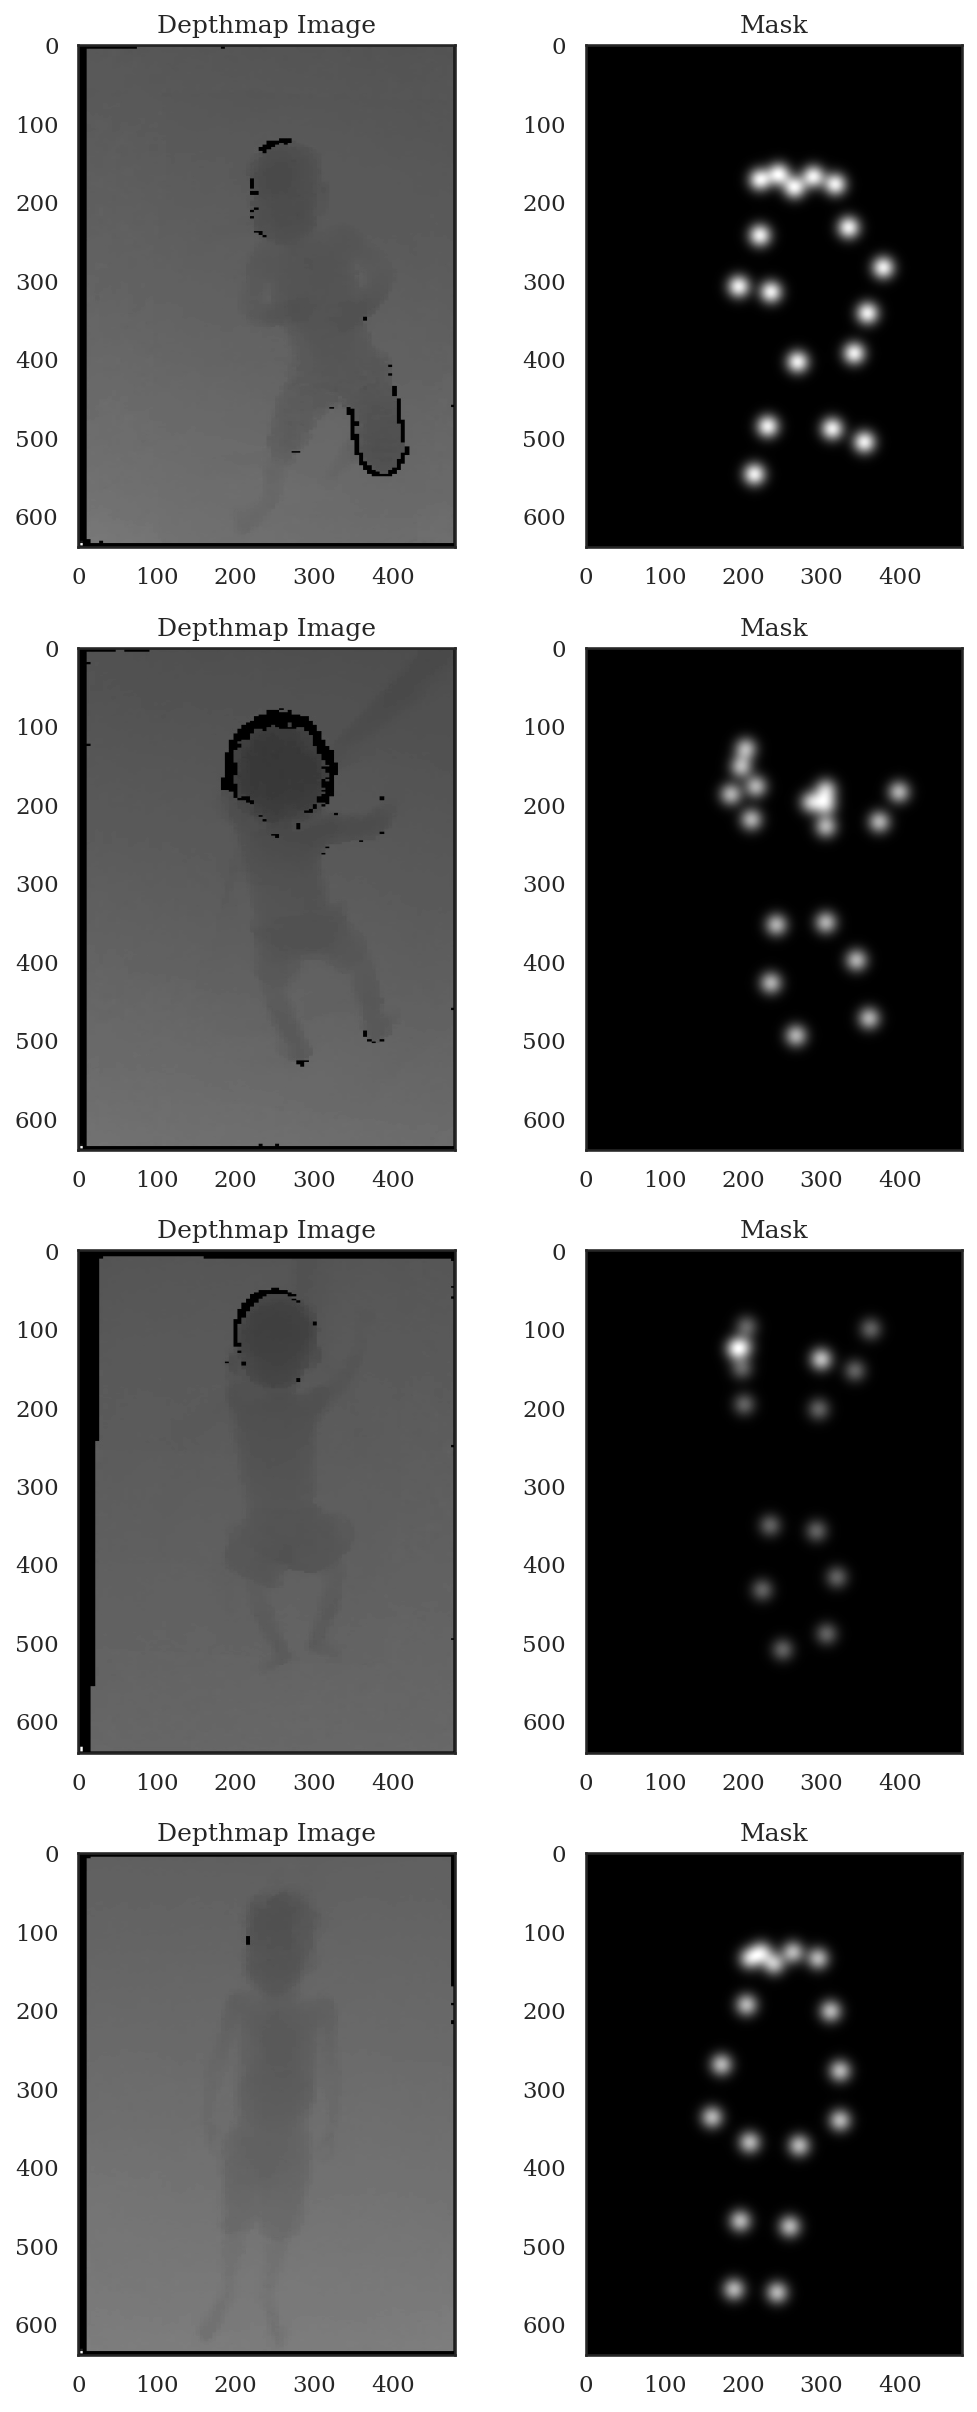

In [3]:
from google.colab.patches import cv2_imshow

# Define the number of images to display
num_images = 4

# Create a figure with enough subplots to display all images
fig, axes = plt.subplots(num_images, 2, figsize=(8, 10*num_images//2))

# Loop through the images
for i in range(num_images):
    # Load the depthmap image and mask
    img = train_inputs[i][..., 0]
    mask = train_masks[i]
    
    # Rescale the depthmap image to 0-255 range for visualization
    rescaled_img = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # Rescale the mask to 0-255 range for visualization
    rescaled_mask = cv2.normalize(mask, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # Display the depthmap image and mask side by side in the same subplot
    axes[i, 0].imshow(rescaled_img, cmap='gray')
    axes[i, 0].set_title('Depthmap Image')
    axes[i, 1].imshow(rescaled_mask, cmap='gray')
    axes[i, 1].set_title('Mask')

# Show the figure
plt.show()

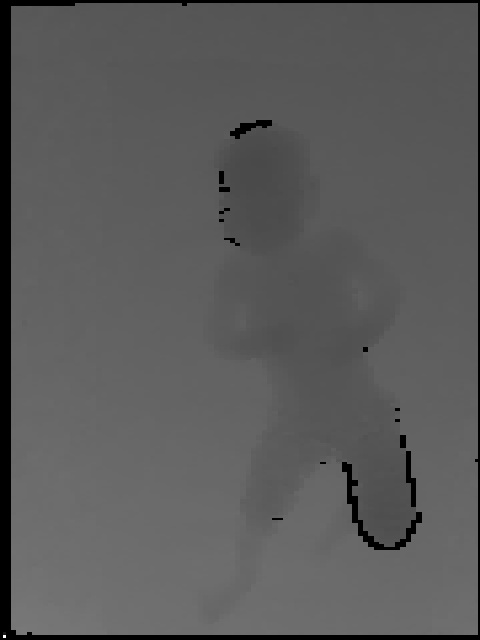

In [4]:
from google.colab.patches import cv2_imshow


# Load the first processed depthmap image and mask from the training set
img = train_inputs[0][..., 0]  # depthmap image

# Scale the depthmap image to the range [0, 255] for display
img = np.uint8(img * 255)

cv2_imshow(img)

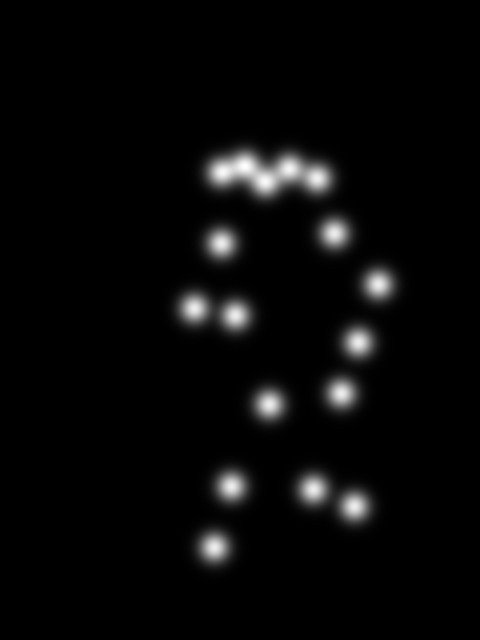

In [5]:
# Load the first mask from train_masks
mask = train_masks[0]

# Rescale the mask to 0-255 range for visualization
rescaled_mask = cv2.normalize(mask, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# Display the mask
cv2_imshow(rescaled_mask)


In [7]:
BATCH_SIZE = 4
HEIGHT = 640
WIDTH = 480

# Load the preprocessed training and validation datasets
train_data = tf.data.Dataset.from_tensor_slices((train_inputs, train_outputs)).batch(BATCH_SIZE)
val_data = tf.data.Dataset.from_tensor_slices((val_inputs, val_outputs)).batch(BATCH_SIZE)

# Define the loss function and optimizer
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()
metrics = [tf.keras.metrics.RootMeanSquaredError(name='RMSE'),
           tf.keras.metrics.MeanSquaredError(name='MSE'),
           tf.keras.metrics.MeanAbsoluteError(name='MAE')]

# Define the model architecture
model = tf.keras.models.Sequential([
    # Convolutional layers
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(HEIGHT, WIDTH, 2)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    # Flatten the output of the convolutional layers
    tf.keras.layers.Flatten(),
    # Fully connected layers
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])
# Compile the model with the loss function and optimizer
model.compile(loss=loss_fn, optimizer=optimizer, metrics=metrics)
# Train the model for multiple epochs
EPOCHS = 30
train_loss_values = []
val_loss_values = []
train_metric_values = {metric.name: [] for metric in metrics}
val_metric_values = {metric.name: [] for metric in metrics}
for epoch in range(EPOCHS):
    print('Epoch', epoch+1)
    epoch_train_loss_values = []
    epoch_train_metric_values = {metric.name: [] for metric in metrics}
    for step, (x_batch, y_batch) in enumerate(train_data):
        with tf.GradientTape() as tape:
            # Make predictions and calculate loss
            y_pred = model(x_batch, training=True)
            loss_value = loss_fn(y_batch, y_pred)
            metric_values = {metric.name: metric(y_batch, y_pred) for metric in metrics}

        # Compute gradients and update weights
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Log training progress
        epoch_train_loss_values.append(loss_value.numpy())
        for metric in metrics:
            epoch_train_metric_values[metric.name].append(metric_values[metric.name].numpy())
        if step % 1 == 0:
            print('Training loss at step', step, '=', loss_value.numpy())

    # Log training metrics for this epoch
    train_loss_values.append(np.mean(epoch_train_loss_values))
    for metric in metrics:
        train_metric_values[metric.name].append(np.mean(epoch_train_metric_values[metric.name]))

    # Evaluate the model on the validation set
    val_loss = 0
    val_metric_values_epoch = {metric.name: [] for metric in metrics}
    for x_val, y_val in val_data:
        y_val_pred = model(x_val, training=False)
        val_loss += loss_fn(y_val, y_val_pred)
        metric_values = {metric.name: metric(y_val, y_val_pred) for metric in metrics}
        for metric in metrics:
            val_metric_values_epoch[metric.name].append(metric_values[metric.name].numpy())
    print('Validation loss =', val_loss.numpy())

    # Log validation metrics for this epoch
    val_loss_values.append(val_loss.numpy())
    for metric in metrics:
        val_metric_values[metric.name].append(np.mean(val_metric_values_epoch[metric.name]))

# Save the metrics
np.savez('metrics.npz', 
         train_loss=train_loss_values, val_loss=val_loss_values, 
         train_metric=train_metric_values, val_metric=val_metric_values)

model.save('model.h5')

Epoch 1
Training loss at step 0 = 5473.0195
Training loss at step 1 = 2530.5557
Validation loss = 971.2482
Epoch 2
Training loss at step 0 = 111.12922
Training loss at step 1 = 2169.8591
Validation loss = 596.14056
Epoch 3
Training loss at step 0 = 39.291553
Training loss at step 1 = 337.21005
Validation loss = 1087.091
Epoch 4
Training loss at step 0 = 896.8159
Training loss at step 1 = 647.905
Validation loss = 313.19855
Epoch 5
Training loss at step 0 = 358.85834
Training loss at step 1 = 13.266916
Validation loss = 1053.7135
Epoch 6
Training loss at step 0 = 119.42675
Training loss at step 1 = 476.43335
Validation loss = 1409.4761
Epoch 7
Training loss at step 0 = 201.17805
Training loss at step 1 = 61.44727
Validation loss = 153.93596
Epoch 8
Training loss at step 0 = 62.890038
Training loss at step 1 = 122.630295
Validation loss = 215.8619
Epoch 9
Training loss at step 0 = 268.6398
Training loss at step 1 = 151.85068
Validation loss = 127.70682
Epoch 10
Training loss at step 0 = 

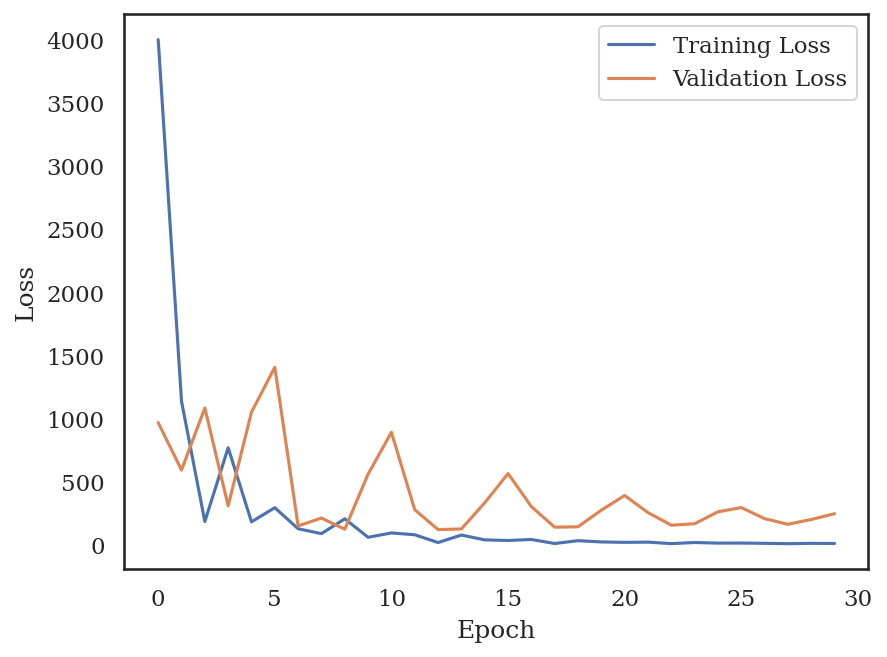

In [8]:
# Load the saved metrics
metrics = np.load('metrics.npz')
train_loss_values = metrics['train_loss']
val_loss_values = metrics['val_loss']

# Plot the loss curves
plt.plot(train_loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


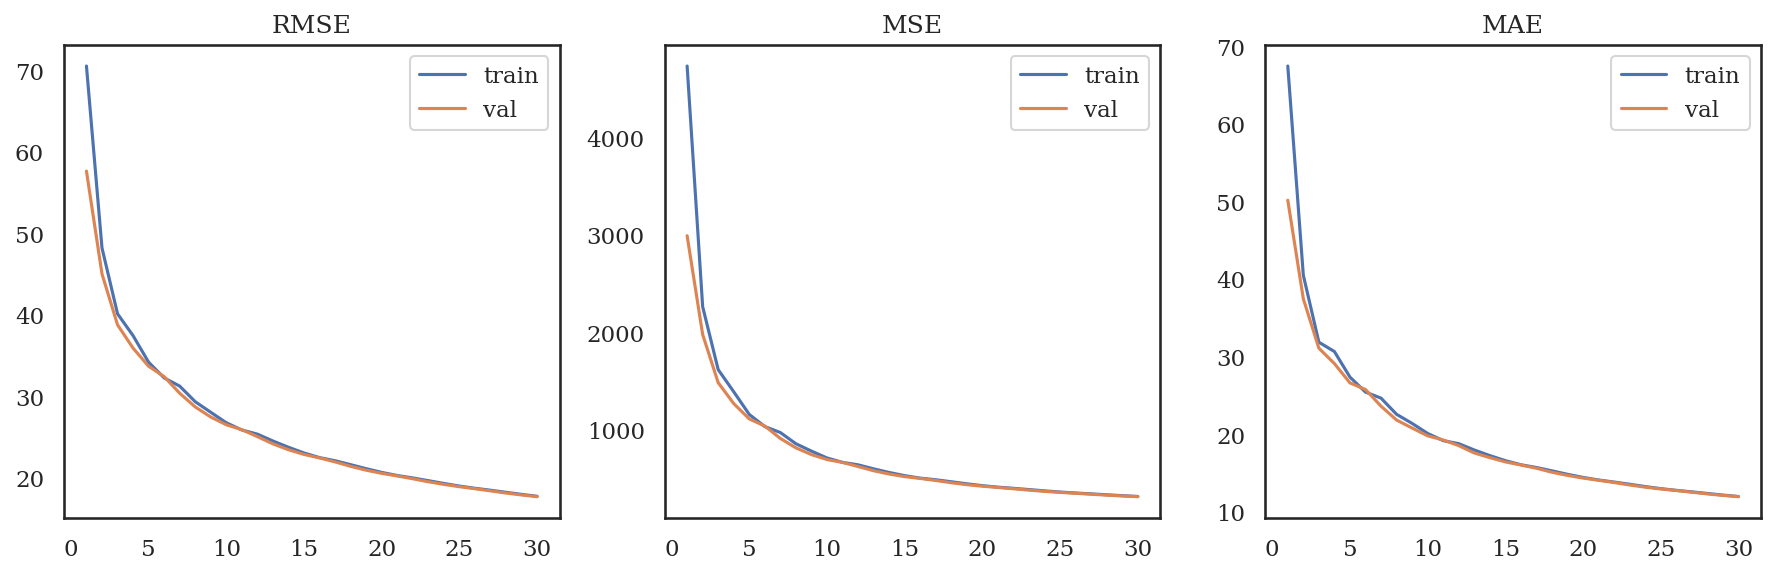

In [9]:
# Define the epochs
epochs = range(1, len(train_metric_values['RMSE'])+1)

# Create the figure and axes objects
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Loop through each metric and plot the values
metrics = ['RMSE', 'MSE', 'MAE']
for i, metric in enumerate(metrics):
    axs[i].plot(epochs, train_metric_values[metric], label='train')
    axs[i].plot(epochs, val_metric_values[metric], label='val')
    axs[i].set_title(metric)
    axs[i].legend()

plt.tight_layout()
plt.show()

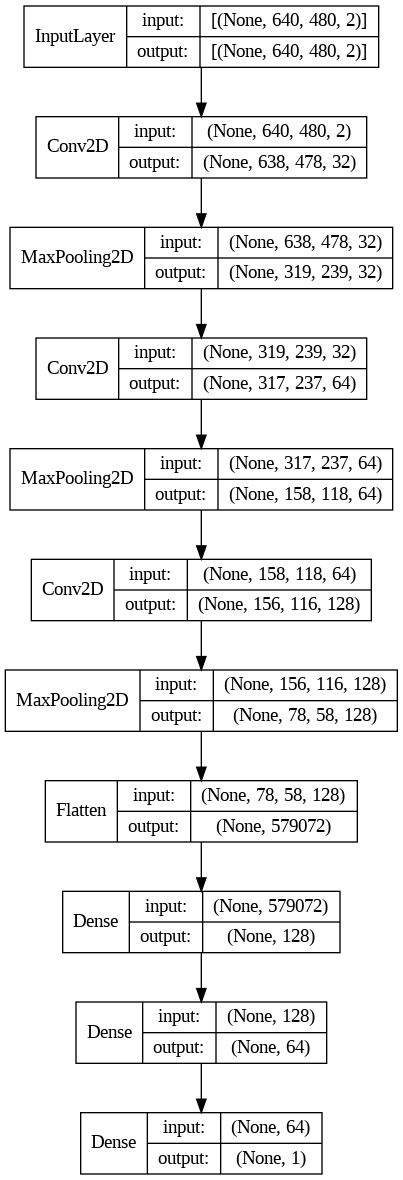

In [10]:
from tensorflow.keras.utils import plot_model
# Plot the model
plot_model(model, show_shapes=True, show_layer_names=False, dpi=96)

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 638, 478, 32)      608       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 319, 239, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 317, 237, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 158, 118, 64)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 156, 116, 128)     73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 78, 58, 128)     